In [170]:
import numpy as np

import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

RANDOM_STATE = 1

In [171]:
X, y = make_classification(
    n_samples=30000,
    n_features=20,
    n_classes=8,
    random_state=RANDOM_STATE,
    n_informative=5,
)

X = pd.DataFrame(X)
y = pd.Series(y)

# y1 = y.copy()
# y2 = y[y >= 4]
# y1[y2.index] = y1[y2.index].map({i: 4 for i in range(4, 8)})

# X1 = X.copy()
# X2 = X.loc[y2.index]

y1_train_index, y1_val_index = train_test_split(
    X.index, shuffle=True, stratify=y, random_state=RANDOM_STATE
)
X1_train, X1_val, y1_train, y1_val = (
    X.loc[y1_train_index],
    X.loc[y1_val_index],
    y.loc[y1_train_index],
    y.loc[y1_val_index],
)

y2_train = y1_train.loc[y1_train >= 4]
y2_val = y1_val.loc[y1_val >= 4]

X2_train = X1_train.loc[y2_train.index]
X2_val = X1_val.loc[y2_val.index]

y1_train[y2_train.index] = y1_train[y2_train.index].map({i: 4 for i in range(4, 8)})
y1_val[y2_val.index] = y1_val[y2_val.index].map({i: 4 for i in range(4, 8)})

In [172]:
y2_train.value_counts()

4    2822
5    2817
7    2806
6    2805
Name: count, dtype: int64

In [173]:
y1_train.value_counts()

4    11250
0     2816
3     2816
1     2815
2     2803
Name: count, dtype: int64

In [174]:
assert y1_train.value_counts()[4] == y2_train.shape[0]

In [175]:
model1 = LogisticRegression(random_state=RANDOM_STATE)
model1.fit(X1_train, y1_train)

model2 = LogisticRegression(random_state=RANDOM_STATE)
model2.fit(X2_train, y2_train)

LogisticRegression(random_state=1)

In [176]:
pred1 = pd.DataFrame(model1.predict(X1_val), index=X1_val.index)
pred2 = pd.DataFrame(model2.predict(X2_val), index=X2_val.index)

precision1, recall1, f1_score1, support1 = precision_recall_fscore_support(y1_val, pred1)
precision2, recall2, f1_score2, support2 = precision_recall_fscore_support(y2_val, pred2)

In [177]:
def create_table(precision, recall, f1_score): 
    table_buff = pd.DataFrame(precision)
    table_buff.columns = ['precision']

    for metric, metric_name in zip([recall, f1_score], ['recall', 'f1_score']):
        metric = pd.DataFrame(metric)
        metric.columns = [metric_name]
        table_buff = table_buff.join(metric)
    
    return table_buff

In [178]:
merrics1 = create_table(precision1, recall1, f1_score1)
merrics2 = create_table(precision2, recall2, f1_score2)

<Axes: >

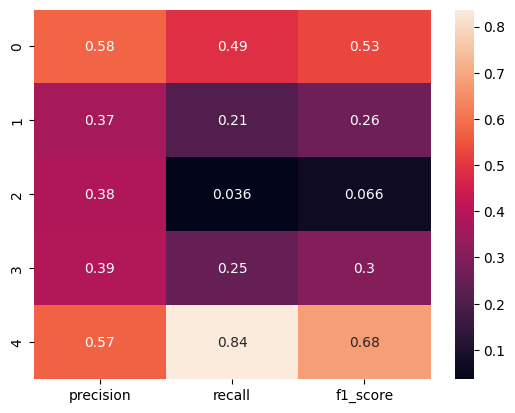

In [179]:
sns.heatmap(merrics1, annot=True)

<Axes: >

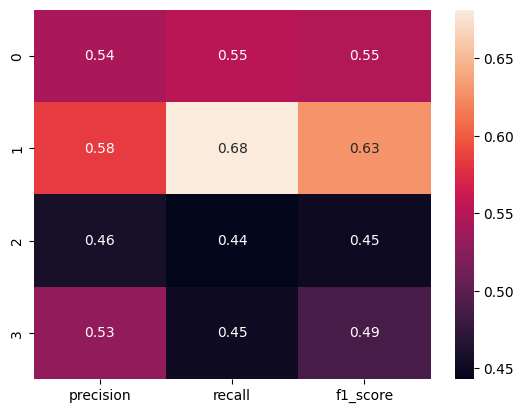

In [180]:
sns.heatmap(merrics2, annot=True)

In [196]:
pred = pred1.copy()
pred.columns = ['pred1']

y1_val.name = 'gt1'
pred2.columns = ['pred2']
y2_val.name = 'gt2'

pred = pred.join(y1_val)
pred = pred.join(pred2)
pred = pred.join(y2_val)

In [197]:
pred

,pred1,gt1,pred2,gt2
14671,4,4,6.0,7.0
3741,4,4,7.0,5.0
20916,4,2,NaN,NaN
17544,4,3,NaN,NaN
17845,4,2,NaN,NaN
...,...,...,...,...
25261,4,3,NaN,NaN
17498,4,4,6.0,7.0
19655,4,4,4.0,6.0
16880,4,3,NaN,NaN


In [210]:
def new_pred_gt(X):
    pred1 = X['pred1']
    gt1 = X['gt1']
    pred2 = X['pred2']
    gt2 = X['gt2']
    
    if gt1 == 4 and pred1 == gt1:
        return [pred2, gt2]
    elif gt1 == 4 and pred1 != gt1:
        return [pred1, gt2]
    elif gt1 != 4:
        return [pred1, gt1]
    assert False


In [211]:
pred[['pred', 'gt']] = pred.apply(new_pred_gt, axis=1, result_type='expand')

In [213]:
pred[(pred['gt1'] == pred['pred1']) & (pred['gt1'] == 4)]

,pred1,gt1,pred2,gt2,pred,gt
14671,4,4,6.0,7.0,6.0,7.0
3741,4,4,7.0,5.0,7.0,5.0
23185,4,4,5.0,7.0,5.0,7.0
23288,4,4,5.0,5.0,5.0,5.0
15704,4,4,6.0,6.0,6.0,6.0
...,...,...,...,...,...,...
16906,4,4,4.0,4.0,4.0,4.0
15622,4,4,4.0,4.0,4.0,4.0
449,4,4,7.0,7.0,7.0,7.0
17498,4,4,6.0,7.0,6.0,7.0


In [214]:
pred[(pred['gt1'] == 4) & (pred['gt1'] != pred['pred1'])]

,pred1,gt1,pred2,gt2,pred,gt
5353,3,4,7.0,5.0,3.0,5.0
8043,3,4,7.0,5.0,3.0,5.0
10154,1,4,4.0,4.0,1.0,4.0
7671,0,4,4.0,4.0,0.0,4.0
27755,3,4,5.0,5.0,3.0,5.0
...,...,...,...,...,...,...
5107,3,4,7.0,5.0,3.0,5.0
12378,3,4,7.0,5.0,3.0,5.0
22948,1,4,6.0,7.0,1.0,7.0
2862,0,4,5.0,4.0,0.0,4.0


In [215]:
pred[(pred['gt1'] != 4)]

,pred1,gt1,pred2,gt2,pred,gt
20916,4,2,NaN,NaN,4.0,2.0
17544,4,3,NaN,NaN,4.0,3.0
17845,4,2,NaN,NaN,4.0,2.0
14726,4,0,NaN,NaN,4.0,0.0
20708,0,1,NaN,NaN,0.0,1.0
...,...,...,...,...,...,...
19701,4,0,NaN,NaN,4.0,0.0
26269,4,3,NaN,NaN,4.0,3.0
25261,4,3,NaN,NaN,4.0,3.0
16880,4,3,NaN,NaN,4.0,3.0


In [216]:
pred

,pred1,gt1,pred2,gt2,pred,gt
14671,4,4,6.0,7.0,6.0,7.0
3741,4,4,7.0,5.0,7.0,5.0
20916,4,2,NaN,NaN,4.0,2.0
17544,4,3,NaN,NaN,4.0,3.0
17845,4,2,NaN,NaN,4.0,2.0
...,...,...,...,...,...,...
25261,4,3,NaN,NaN,4.0,3.0
17498,4,4,6.0,7.0,6.0,7.0
19655,4,4,4.0,6.0,4.0,6.0
16880,4,3,NaN,NaN,4.0,3.0


In [218]:
pred.pred

14671    6.0
3741     7.0
20916    4.0
17544    4.0
17845    4.0
        ... 
25261    4.0
17498    6.0
19655    4.0
16880    4.0
19788    1.0
Name: pred, Length: 7500, dtype: float64

14671    7.0
3741     5.0
20916    2.0
17544    3.0
17845    2.0
        ... 
25261    3.0
17498    7.0
19655    6.0
16880    3.0
19788    1.0
Name: gt, Length: 7500, dtype: float64

In [224]:
precision, recall, f1_score, support = precision_recall_fscore_support(pred['gt'], pred['pred'])
merrics = create_table(precision, recall, f1_score)

<Axes: >

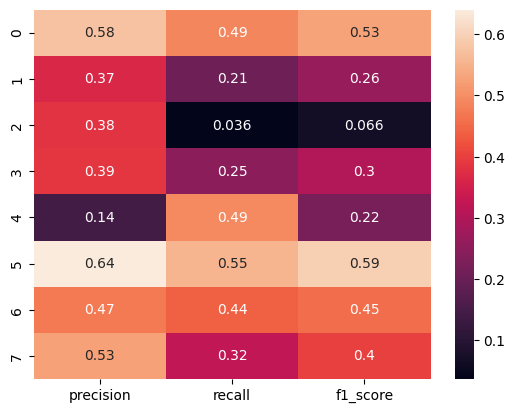

In [225]:
sns.heatmap(merrics, annot=True)

<Axes: >

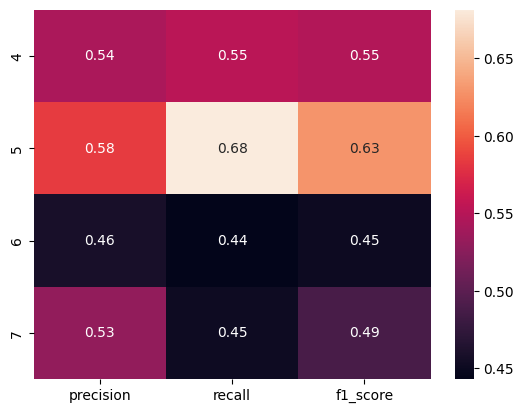

In [230]:
merrics2.index = [4, 5, 6, 7]
sns.heatmap(merrics2, annot=True)